[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/SatelliteVu/SatelliteVu-AWS-Disaster-Response-Hackathon/blob/main/dataset_preparation/FirmsAPIExample.ipynb)

In [ ]:
# Example of continental NA (roughly)
from datetime import datetime
import sys, os
sys.path.append("../")

import geopandas as gpd
import pandas as pd

from src.constants import FIRMS_API_KEY, DEFAULT_PARAMS
from src.data_sources import (cluster_fires, 
                              create_chip_bounds, 
                              ndvi_from_topleft, 
                              landcover_from_topleft, 
                              atmospheric_from_topleft, 
                              fires_from_topleft,
                              elevation_from_topleft)


bbox = "19.999999999995737,-8.720000000001733,20.319999999995737,-8.400000000001732"

ds = pd.read_csv(
    f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/{FIRMS_API_KEY}/VIIRS_SNPP_SP/{bbox}/10/2020-07-10"
)
gdf = gpd.GeoDataFrame(
    ds, geometry=gpd.points_from_xy(ds.longitude, ds.latitude), crs="EPSG:4326"
)

In [8]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'True'
elevation_footprints = gpd.GeoDataFrame.from_file('s3://copernicus-dem-30m/grid.zip')

In [9]:
clustered_fires = cluster_fires(gdf, min_cluster_points=25)
chip_bounds = create_chip_bounds(clustered_fires)

sample = chip_bounds.iloc[0]

ndvi = ndvi_from_topleft([sample['top'], 
                          sample['left']], 
                         int(sample['epsg']), 
                         sample['date'])

lc = landcover_from_topleft([sample['top'], 
                             sample['left']],
                            int(sample['epsg']))

ad = atmospheric_from_topleft([sample['top'], 
                                    sample['left']], 
                                   int(sample['epsg']), 
                                   sample['date'],
                                   DEFAULT_PARAMS)

elevation = elevation_from_topleft([sample['top'], 
                                    sample['left']],
                                   int(sample['epsg']),
                                   elevation_footprints)

fires = fires_from_topleft([sample['top'], 
                            sample['left']], 
                           int(sample['epsg']), 
                           sample['date'],
                           gdf)

Text(0.5, 1.0, 'elevation')

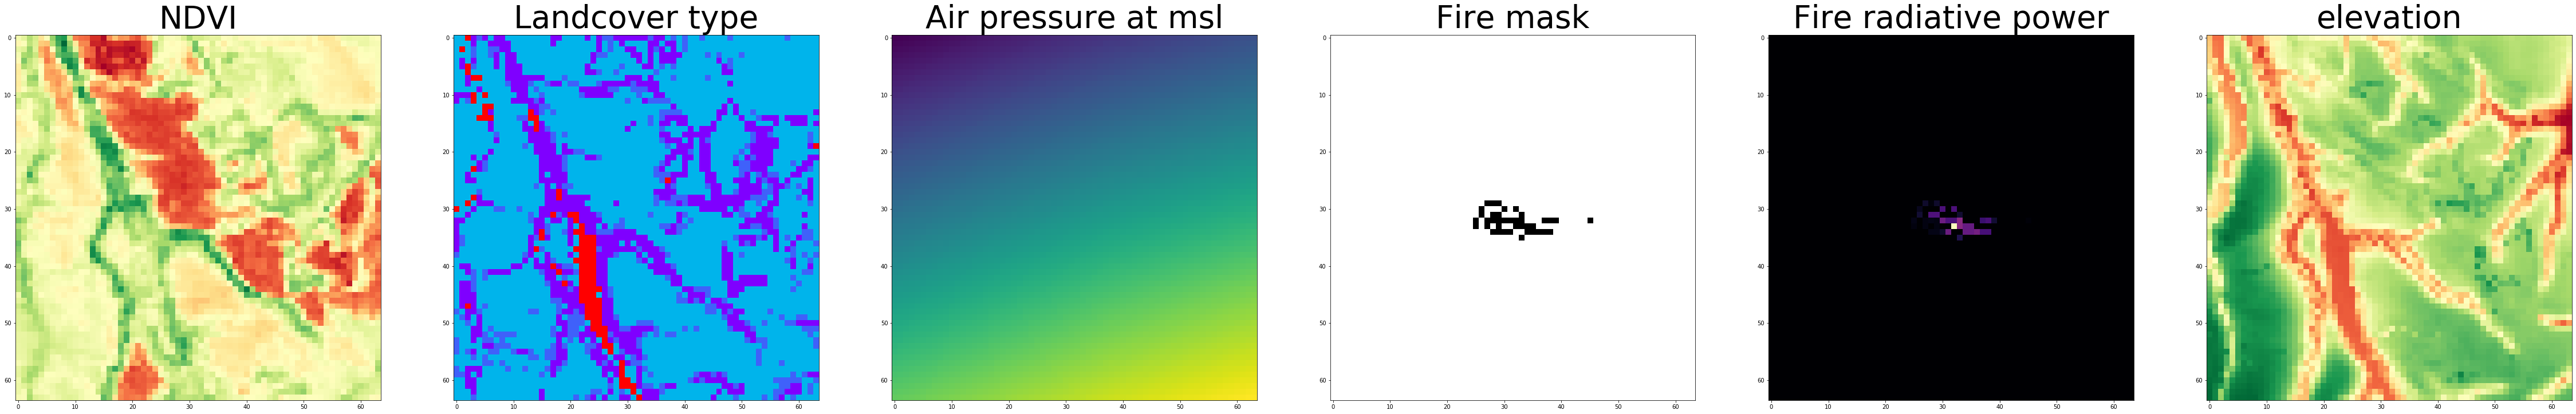

In [15]:
import matplotlib.pyplot as plt

fontdict = {'fontsize': 55}

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(80,16))
ax1.imshow(ndvi, cmap='RdYlGn')
ax1.set_title('NDVI', fontdict=fontdict)
ax2.imshow(lc, cmap='rainbow')
ax2.set_title('Landcover type', fontdict=fontdict)
ax3.imshow(ad.air_pressure_at_mean_sea_level.values[0])
ax3.set_title('Air pressure at msl', fontdict=fontdict)
ax4.imshow(fires.bool.values, cmap='Greys')
ax4.set_title('Fire mask', fontdict=fontdict)
ax5.imshow(fires.frp.values, cmap='magma')
ax5.set_title('Fire radiative power', fontdict=fontdict)
ax6.imshow(elevation, cmap='RdYlGn')
ax6.set_title('elevation', fontdict=fontdict)
